In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import pickle
from scipy.interpolate import interpn
#from vol_greedy_polar_coordinates import greedy_geosteering_polar, plot_3d_traj

Differential evolution is a heuristic approach for the global optimisation of nonlinear and non- differentiable continuous space functions.

The differential evolution algorithm belongs to a broader family of evolutionary computing algorithms. Similar to other popular direct search approaches, such as genetic algorithms and evolution strategies, the differential evolution algorithm starts with an initial population of candidate solutions. These candidate solutions are iteratively improved by introducing mutations into the population, and retaining the fittest candidate solutions that yield a lower objective function value.

In [11]:
import os
os.chdir('C:\\Users\\Максимилиан\\Desktop\\Aramco\\Geosteering\\Algorithm\\3D_geosteering')
os.getcwd()

'C:\\Users\\Максимилиан\\Desktop\\Aramco\\Geosteering\\Algorithm\\3D_geosteering'

In [12]:
# import 3d cube
file1 = '3D_301.833.2055'
file2 = '3D_400.400.1650'
file3 = '3D_80.80.230'
#file = open("./RL/3D_301.833.2055.pickle",'rb')
file = open(f"{file2}.pickle",'rb')
cube_3d = pickle.load(file)

In [15]:

class DE_algo:
    def __init__(self, cube_3d):
        self.cube_3d = cube_3d

        x = np.linspace(0, cube_3d.shape[0] - 1, cube_3d.shape[0])
        y = np.linspace(0, cube_3d.shape[1] - 1, cube_3d.shape[1])
        z = np.linspace(0, cube_3d.shape[2] - 1, cube_3d.shape[2])
        self.points = (x, y, z)

    def get_vec(self, inc, azi, length, nev=False, deg=True):
        """
        Convert inc and azi into a vector.
        Params:
            inc: array of n floats
                Inclination relative to the z-axis (up)
            azi: array of n floats
                Azimuth relative to the y-axis
            r: float or array of n floats
                Scalar to return a scaled vector
        Returns:
            An (n,3) array of vectors
        """
        if deg:
            inc_rad, azi_rad = np.radians(np.array([inc, azi]))
        else:
            inc_rad = inc
            azi_rad = azi
        y = length * np.sin(inc_rad) * np.cos(azi_rad)
        x = length * np.sin(inc_rad) * np.sin(azi_rad)
        z = length * np.cos(inc_rad)

        #     if nev:
        #         vec = np.array([y, x, z]).T
        #     else:
        #         vec = np.array([x, y, z]).T
        return np.stack([x, y, z])

    def obj(self, angles, *state):
        penalty = 0
        vec_diff = self.get_vec(angles[0], angles[1], state[-1])
        #  vec_diff = get_vec(angles[0], 10)
        state_new = [state[0][0] + vec_diff[0], state[0][1] + vec_diff[1], state[0][2] + vec_diff[2]]

        # dogleg severity constraint
        dls_val = np.linalg.norm(angles[0] - state[1][-2]) + np.linalg.norm(angles[1] - state[2][-2])
        if dls_val >= state[3] * state[4]:
            penalty += dls_val * 0.5

        # contraint for high length action
        length_constraint = np.linalg.norm(vec_diff)

        # objective function
        OFV = interpn(self.points, self.cube_3d, state_new, method='nearest') / length_constraint - penalty
        return -OFV

    def DE_planning(self, pop_size=100, num_iters=1000, F=0.7, cr=0.7, bounds=[(0, 180), (0, 92)],
                    length=10, angle_constraint=0.1,
                    init_incl=[0, 0], init_azi=[10, 10],
                    init_pos=[120, 170, 40]):
        """
        1 step differential evolution trajectory planning.
        Params:
            pop_size: int
             population size
            num_iters: int
             define number of iterations
            F: float (0,1)
             scale factor for mutation
            cr: flaot (0,1)
             crossover rate for recombination
            bounds: list of tuples
             bound for searchable paramaters (in our case (azi, inclination))
            angle_constraint: float
             dogleg constraint per m
            length: int
             length of one step

        """
        OFV = 0
        pos = init_pos
        incl_l = init_incl
        azi_l = init_azi
        state = ([pos[0], pos[1], pos[2]], incl_l, azi_l, angle_constraint, length)
        traj_x = [state[0][0]]
        traj_y = [state[0][1]]
        traj_z = [state[0][2]]
        с = 0

        while (traj_z[-1] <= self.cube_3d.shape[2] - 20) and (traj_y[-1] <= self.cube_3d.shape[1] - 20) and \
                (traj_x[-1] <= self.cube_3d.shape[0] - 20):
            de_sol = differential_evolution(self.obj, bounds, args=(state), mutation = F, popsize = pop_size, maxiter = num_iters, updating='deferred', disp=False).x
            incl_l.append(de_sol[0])
            azi_l.append(de_sol[1])
            step = self.get_vec(incl_l[-1], azi_l[-1], length=length)

            traj_x.append(state[0][0] + step[0])
            traj_y.append(state[0][1] + step[1])
            traj_z.append(state[0][2] + step[2])
            print(с, traj_x[-1], traj_y[-1], traj_z[-1])
            state[0][0] = state[0][0] + step[0]
            state[0][1] = state[0][1] + step[1]
            state[0][2] = state[0][2] + step[2]
            state_new = [state[0][0], state[0][1], state[0][2]]

            OFV += interpn(self.points, self.cube_3d, state_new, method='nearest')
            с += 1
        print(OFV)
        return OFV, np.stack([traj_x, traj_y, traj_z])

In [16]:
DE_algos = DE_algo(cube_3d)
OFV, traj = DE_algos.DE_planning()
ofv_list = []

0 120.0108151927475 170.06299153996721 49.99979575278907
1 120.01253165395924 170.07233051365108 59.999791244654624


KeyboardInterrupt: 

In [17]:
# define objective function
def obj(angles, *state):
    x = np.linspace(0, cube_3d.shape[0] - 1, cube_3d.shape[0])
    y = np.linspace(0, cube_3d.shape[1] - 1, cube_3d.shape[1])
    z = np.linspace(0, cube_3d.shape[2] - 1, cube_3d.shape[2])
    points = (x, y, z)
    penalty = 0
    vec_diff = get_vec(angles[0], angles[1])
  #  vec_diff = get_vec(angles[0], 10)
    state_new = [state[0][0] + vec_diff[0], state[0][1] + vec_diff[1], state[0][2] + vec_diff[2]]
    
    #dogleg severity constraint
    dls_val = np.linalg.norm(angles[0] - state[1][-2]) + np.linalg.norm(angles[1] - state[2][-2])
    if dls_val >= state[3] * state[4]:
                penalty += dls_val * 0.5
    
    # contraint for high length action
    length_constraint = np.linalg.norm(vec_diff)
    # productivity potential 
    OFV = interpn(points, cube_3d, state_new, method = 'nearest') / length_constraint - penalty
    ofv_list.append(OFV)
    return -OFV

In [18]:
obj(angles,*state)

NameError: name 'get_vec' is not defined

In [4]:
# define population size
pop_size = 100
# define number of iterations
iter = 100
# define scale factor for mutation
F = 0.8
# define crossover rate for recombination
cr = 0.7
# 
bounds = [(0,180), (0, 92)]

In [5]:
azi_l = [10,10]
incl_l = [0,0]

angle_constraint = 0.5
length = 10

state = ([120, 170, 40],incl_l,azi_l,angle_constraint, length)
traj_x = [state[0][0]]
traj_y = [state[0][1]]
traj_z = [state[0][2]]
angles = [0, 0]



In [236]:
result = differential_evolution(obj, bounds,args=(state), mutation = F, popsize = pop_size, maxiter=1000,  updating='deferred', disp = False)

In [237]:
result

     fun: -1.4214259234621158
 message: 'Optimization terminated successfully.'
    nfev: 4003
     nit: 19
 success: True
       x: array([ 0.87080109, 11.7237643 ])

In [238]:
OFV = 0

x = np.linspace(0, cube_3d.shape[0] - 1, cube_3d.shape[0])
y = np.linspace(0, cube_3d.shape[1] - 1, cube_3d.shape[1])
z = np.linspace(0, cube_3d.shape[2] - 1, cube_3d.shape[2])
points = (x,y,z)

while (traj_z[-1] <= cube_3d.shape[2] - 20) and (traj_y[-1] <= cube_3d.shape[1] - 20) and \
(traj_x[-1] <= cube_3d.shape[0] - 20):
    de_sol = differential_evolution(obj, bounds, args=(state),mutation = F, popsize = pop_size, maxiter=1000, updating='deferred', disp = False).x
    incl_l.append(de_sol[0])
    azi_l.append(de_sol[1])
    step = get_vec(incl_l[-1], azi_l[-1])
    
    traj_x.append(state[0][0] + step[0])
    traj_y.append(state[0][1] + step[1])
    traj_z.append(state[0][2] + step[2])
    print(traj_x[-1], traj_y[-1], traj_z[-1])
    state[0][0] = state[0][0] + step[0]
    state[0][1] = state[0][1] + step[1]
    state[0][2] = state[0][2] + step[2]
    state_new = [state[0][0], state[0][1], state[0][2]]
    
    OFV += interpn(points, cube_3d, state_new, method = 'nearest')
       

120.00300491202489 170.0293676674615 49.99995642543564
120.0634699509719 170.4455937249219 59.99110750267174
120.06552867244389 170.4834500034873 69.99103563560544
120.23446583467044 171.57119852875175 79.93026414595793
120.26135679442014 171.94743728790428 89.92314767737143
120.49553024379505 173.04410486078444 99.8600729075521
120.49607597435268 173.2416848098957 109.85812081031227
120.88517848906781 175.10977888435667 119.67437385116274
120.90908842147361 175.6665301705882 129.6588345937573
121.3371796988591 177.5526921503854 139.4700083688055
121.3382125958837 177.58600754136245 149.4699528195436
121.78620376067691 179.56693599243914 159.2615423936619
121.7918058354499 179.70632344885064 169.2605693340073
122.37270351495916 181.90509825138415 178.998533559331
122.41015108047482 182.4623450709738 188.98292506116496
122.90566899138125 184.25366807863236 198.80868833341023
122.90942923368969 184.4436498145671 208.80688281044402
123.49668202830497 186.76940038629274 218.51492166663607


pop_size = 100 OFV = 2103
pop_size = 500 OFV = 2138


angle_constraint = 10 OFV = 2539

In [239]:
OFV

array([1736.49621303])

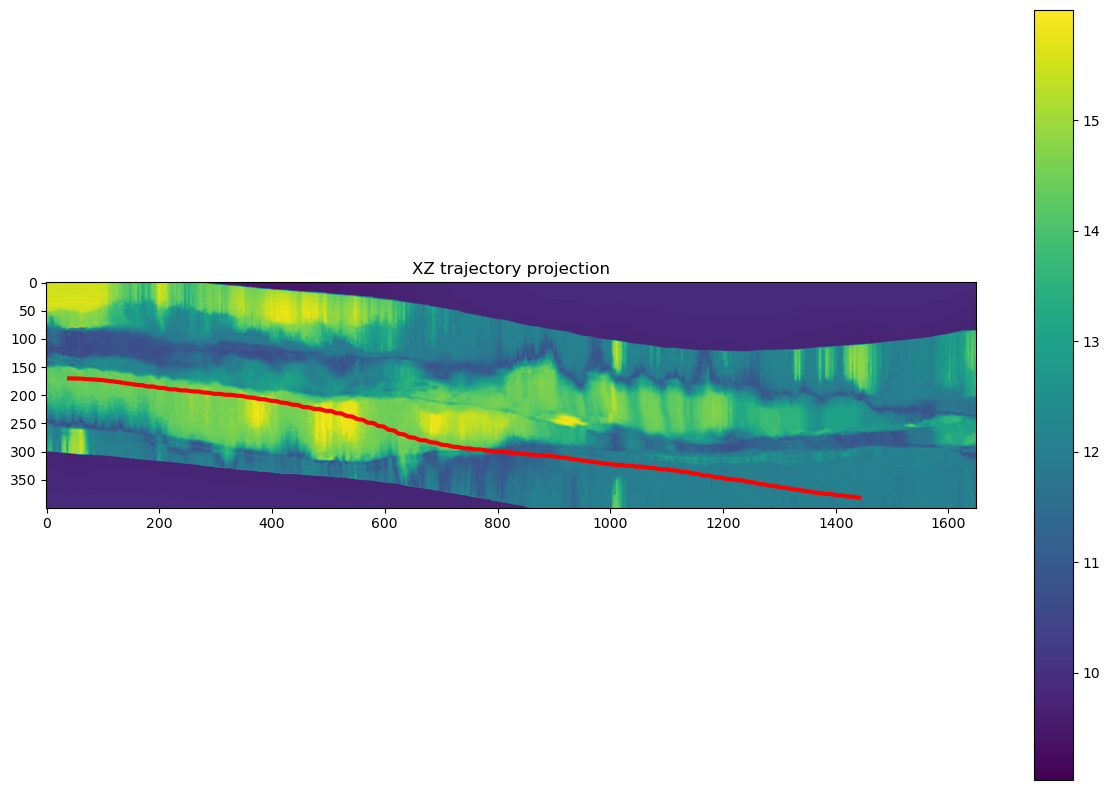

In [218]:
def plot_results(volume_cube, traj_x, traj_y, traj_z, along_axis = 'y'):

    x = []
    z = []
    y = []
    property_along_y = []
    property_along_x = []
    property_along_z = []
    for i in range(0,len(traj_x)):
        x.append(traj_x[i])
        z.append(traj_z[i])
        y.append(traj_y[i])
        property_along_y.append(volume_cube[round(traj_x[i]),:,round(traj_z[i])].T)
        property_along_x.append(volume_cube[:,round(traj_y[i]),round(traj_z[i])].T)
        property_along_z.append(volume_cube[round(traj_x[i]),round(traj_y[i]),:].T)

    x_t = np.array(x)
    z_t = np.array(z)
    y_t = np.array(y)
    
    fig, ax = plt.subplots(1,1, figsize = (15,10))
    property_along_y_arr = np.array(property_along_y)
    property_along_x_arr = np.array(property_along_x)
    property_along_z_arr = np.array(property_along_z)
  #  ax.plot(z_t, color = 'r', linewidth = 3 )
    ax.set_title('XZ trajectory projection')

    #ax.imshow(property_along_z_arr.T[::-1])
    if along_axis == 'y':
        p_map = plt.imshow(cube_3d[:,round(traj_y[22]),:])
      #  p_map = ax.imshow(property_along_y_arr, aspect='auto')
        ax.plot(y_t, color = 'r', linewidth = 3 )
    elif along_axis == 'z':
        p_map = plt.imshow(cube_3d[round(traj_x[22]),:,:])
       # p_map =  ax.imshow(property_along_z_arr.T, aspect='auto')
        ax.plot(z_t,y_t, color = 'r', linewidth = 3 )
    else:
        p_map = plt.imshow(cube_3d[:,:,round(traj_z[22])])
      #  p_map = ax.imshow(property_along_x_arr, aspect='auto')
        ax.plot(x_t, color = 'r', linewidth = 3 )
    plt.colorbar(p_map)
    
plot_results(cube_3d, traj_x, traj_y, traj_z, along_axis = 'z')

In [219]:
plot_3d_traj(traj_x, traj_y, traj_z)